### read video
  - pip install imageio (admin)
  - conda install ffmpeg -c conda-forge (admin)

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
os.environ['GLOG_minloglevel'] = '3'

import _init_paths
import caffe
import cv2
import numpy as np
#from python_wrapper import *

import matplotlib.pyplot as plt

from IPython.display import clear_output
import imageio

In [2]:
def bbreg(boundingbox, reg):
    reg = reg.T 
    
    # calibrate bouding boxes
    if reg.shape[1] == 1:
        print "reshape of reg"
        pass # reshape of reg
    w = boundingbox[:,2] - boundingbox[:,0] + 1
    h = boundingbox[:,3] - boundingbox[:,1] + 1

    bb0 = boundingbox[:,0] + reg[:,0]*w
    bb1 = boundingbox[:,1] + reg[:,1]*h
    bb2 = boundingbox[:,2] + reg[:,2]*w
    bb3 = boundingbox[:,3] + reg[:,3]*h
    
    boundingbox[:,0:4] = np.array([bb0, bb1, bb2, bb3]).T
    #print "bb", boundingbox
    return boundingbox

In [3]:
def pad(boxesA, w, h):
    boxes = boxesA.copy() # shit, value parameter!!!
    #print '#################'
    #print 'boxes', boxes
    #print 'w,h', w, h
    
    tmph = boxes[:,3] - boxes[:,1] + 1
    tmpw = boxes[:,2] - boxes[:,0] + 1
    numbox = boxes.shape[0]

    #print 'tmph', tmph
    #print 'tmpw', tmpw

    dx = np.ones(numbox)
    dy = np.ones(numbox)
    edx = tmpw 
    edy = tmph

    x = boxes[:,0:1][:,0]
    y = boxes[:,1:2][:,0]
    ex = boxes[:,2:3][:,0]
    ey = boxes[:,3:4][:,0]
   
   
    tmp = np.where(ex > w)[0]
    if tmp.shape[0] != 0:
        edx[tmp] = -ex[tmp] + w-1 + tmpw[tmp]
        ex[tmp] = w-1

    tmp = np.where(ey > h)[0]
    if tmp.shape[0] != 0:
        edy[tmp] = -ey[tmp] + h-1 + tmph[tmp]
        ey[tmp] = h-1

    tmp = np.where(x < 1)[0]
    if tmp.shape[0] != 0:
        dx[tmp] = 2 - x[tmp]
        x[tmp] = np.ones_like(x[tmp])

    tmp = np.where(y < 1)[0]
    if tmp.shape[0] != 0:
        dy[tmp] = 2 - y[tmp]
        y[tmp] = np.ones_like(y[tmp])
    
    # for python index from 0, while matlab from 1
    dy = np.maximum(0, dy-1)
    dx = np.maximum(0, dx-1)
    y = np.maximum(0, y-1)
    x = np.maximum(0, x-1)
    edy = np.maximum(0, edy-1)
    edx = np.maximum(0, edx-1)
    ey = np.maximum(0, ey-1)
    ex = np.maximum(0, ex-1)
    
    #print "dy"  ,dy 
    #print "dx"  ,dx 
    #print "y "  ,y 
    #print "x "  ,x 
    #print "edy" ,edy
    #print "edx" ,edx
    #print "ey"  ,ey 
    #print "ex"  ,ex 


    #print 'boxes', boxes
    return [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph]

In [4]:
def rerec(bboxA):
    # convert bboxA to square
    w = bboxA[:,2] - bboxA[:,0]
    h = bboxA[:,3] - bboxA[:,1]
    l = np.maximum(w,h).T
    
    #print 'bboxA', bboxA
    #print 'w', w
    #print 'h', h
    #print 'l', l
    bboxA[:,0] = bboxA[:,0] + w*0.5 - l*0.5
    bboxA[:,1] = bboxA[:,1] + h*0.5 - l*0.5 
    bboxA[:,2:4] = bboxA[:,0:2] + np.repeat([l], 2, axis = 0).T 
    return bboxA

In [5]:
def nms(boxes, threshold, type):
    """nms
    :boxes: [:,0:5]
    :threshold: 0.5 like
    :type: 'Min' or others
    :returns: TODO
    """
    if boxes.shape[0] == 0:
        return np.array([])
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    s = boxes[:,4]
    area = np.multiply(x2-x1+1, y2-y1+1)
    I = np.array(s.argsort()) # read s using I
    
    pick = [];
    while len(I) > 0:
        xx1 = np.maximum(x1[I[-1]], x1[I[0:-1]])
        yy1 = np.maximum(y1[I[-1]], y1[I[0:-1]])
        xx2 = np.minimum(x2[I[-1]], x2[I[0:-1]])
        yy2 = np.minimum(y2[I[-1]], y2[I[0:-1]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        if type == 'Min':
            o = inter / np.minimum(area[I[-1]], area[I[0:-1]])
        else:
            o = inter / (area[I[-1]] + area[I[0:-1]] - inter)
        pick.append(I[-1])
        I = I[np.where( o <= threshold)[0]]
    return pick

In [6]:
def generateBoundingBox(map, reg, scale, t):
    stride = 2
    cellsize = 12
    map = map.T
    dx1 = reg[0,:,:].T
    dy1 = reg[1,:,:].T
    dx2 = reg[2,:,:].T
    dy2 = reg[3,:,:].T
    (x, y) = np.where(map >= t)

    yy = y
    xx = x
    
    '''
    if y.shape[0] == 1: # only one point exceed threshold
        y = y.T
        x = x.T
        score = map[x,y].T
        dx1 = dx1.T
        dy1 = dy1.T
        dx2 = dx2.T
        dy2 = dy2.T
        # a little stange, when there is only one bb created by PNet
        
        #print "1: x,y", x,y
        a = (x*map.shape[1]) + (y+1)
        x = a/map.shape[0]
        y = a%map.shape[0] - 1
        #print "2: x,y", x,y
    else:
        score = map[x,y]
    '''
    #print "dx1.shape", dx1.shape
    #print 'map.shape', map.shape
   

    score = map[x,y]
    reg = np.array([dx1[x,y], dy1[x,y], dx2[x,y], dy2[x,y]])

    if reg.shape[0] == 0:
        pass
    boundingbox = np.array([yy, xx]).T

    bb1 = np.fix((stride * (boundingbox) + 1) / scale).T # matlab index from 1, so with "boundingbox-1"
    bb2 = np.fix((stride * (boundingbox) + cellsize - 1 + 1) / scale).T # while python don't have to
    score = np.array([score])

    boundingbox_out = np.concatenate((bb1, bb2, score, reg), axis=0)

    #print '(x,y)',x,y
    #print 'score', score
    #print 'reg', reg

    return boundingbox_out.T

In [7]:
def drawBoxes(im, boxes):
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    for i in range(x1.shape[0]):
        cv2.rectangle(im, (int(x1[i]), int(y1[i])), (int(x2[i]), int(y2[i])), (0,255,0), 1)
    return im

In [8]:
from time import time
_tstart_stack = []
def tic():
    _tstart_stack.append(time())
def toc(fmt="Elapsed: %s s"):
    print fmt % (time()-_tstart_stack.pop())

In [9]:
def detect_face(img, minsize, PNet, RNet, ONet, threshold, fastresize, factor):
    
    img2 = img.copy()

    factor_count = 0
    total_boxes = np.zeros((0,9), np.float)
    points = []
    h = img.shape[0]
    w = img.shape[1]
    minl = min(h, w)
    img = img.astype(float)
    m = 12.0/minsize
    minl = minl*m
    

    #total_boxes = np.load('total_boxes.npy')
    #total_boxes = np.load('total_boxes_242.npy')
    #total_boxes = np.load('total_boxes_101.npy')

    
    # create scale pyramid
    scales = []
    while minl >= 12:
        scales.append(m * pow(factor, factor_count))
        minl *= factor
        factor_count += 1
    
    # first stage
    for scale in scales:
        hs = int(np.ceil(h*scale))
        ws = int(np.ceil(w*scale))

        if fastresize:
            im_data = (img-127.5)*0.0078125 # [0,255] -> [-1,1]
            im_data = cv2.resize(im_data, (ws,hs)) # default is bilinear
        else: 
            im_data = cv2.resize(img, (ws,hs)) # default is bilinear
            im_data = (im_data-127.5)*0.0078125 # [0,255] -> [-1,1]
        #im_data = imResample(img, hs, ws); print "scale:", scale


        im_data = np.swapaxes(im_data, 0, 2)
        im_data = np.array([im_data], dtype = np.float)
        PNet.blobs['data'].reshape(1, 3, ws, hs)
        PNet.blobs['data'].data[...] = im_data
        out = PNet.forward()
    
        boxes = generateBoundingBox(out['prob1'][0,1,:,:], out['conv4-2'][0], scale, threshold[0])
        if boxes.shape[0] != 0:
            #print boxes[4:9]
            #print 'im_data', im_data[0:5, 0:5, 0], '\n'
            #print 'prob1', out['prob1'][0,0,0:3,0:3]

            pick = nms(boxes, 0.5, 'Union')

            if len(pick) > 0 :
                boxes = boxes[pick, :]

        if boxes.shape[0] != 0:
            total_boxes = np.concatenate((total_boxes, boxes), axis=0)
         
    #np.save('total_boxes_101.npy', total_boxes)

    #####
    # 1 #
    #####
    print "[1]:",total_boxes.shape[0]
    #print total_boxes
    #return total_boxes, [] 


    numbox = total_boxes.shape[0]
    if numbox > 0:
        # nms
        pick = nms(total_boxes, 0.7, 'Union')
        total_boxes = total_boxes[pick, :]
        print "[2]:",total_boxes.shape[0]
        
        # revise and convert to square
        regh = total_boxes[:,3] - total_boxes[:,1]
        regw = total_boxes[:,2] - total_boxes[:,0]
        t1 = total_boxes[:,0] + total_boxes[:,5]*regw
        t2 = total_boxes[:,1] + total_boxes[:,6]*regh
        t3 = total_boxes[:,2] + total_boxes[:,7]*regw
        t4 = total_boxes[:,3] + total_boxes[:,8]*regh
        t5 = total_boxes[:,4]
        total_boxes = np.array([t1,t2,t3,t4,t5]).T
        #print "[3]:",total_boxes.shape[0]
        #print regh
        #print regw
        #print 't1',t1
        #print total_boxes

        total_boxes = rerec(total_boxes) # convert box to square
        print "[4]:",total_boxes.shape[0]
        
        total_boxes[:,0:4] = np.fix(total_boxes[:,0:4])
        print "[4.5]:",total_boxes.shape[0]
        #print total_boxes
        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = pad(total_boxes, w, h)

    #print total_boxes.shape
    #print total_boxes

    numbox = total_boxes.shape[0]
    if numbox > 0:
        # second stage

        #print 'tmph', tmph
        #print 'tmpw', tmpw
        #print "y,ey,x,ex", y, ey, x, ex, 
        #print "edy", edy

        #tempimg = np.load('tempimg.npy')

        # construct input for RNet
        tempimg = np.zeros((numbox, 24, 24, 3)) # (24, 24, 3, numbox)
        for k in range(numbox):
            tmp = np.zeros((int(tmph[k]) +1, int(tmpw[k]) + 1,3))
          
            #print "dx[k], edx[k]:", dx[k], edx[k]
            #print "dy[k], edy[k]:", dy[k], edy[k]
            #print "img.shape", img[y[k]:ey[k]+1, x[k]:ex[k]+1].shape
            #print "tmp.shape", tmp[dy[k]:edy[k]+1, dx[k]:edx[k]+1].shape

            tmp[int(dy[k]):int(edy[k])+1, int(dx[k]):int(edx[k])+1] = img[int(y[k]):int(ey[k])+1, int(x[k]):int(ex[k])+1]
            #print "y,ey,x,ex", y[k], ey[k], x[k], ex[k]
            #print "tmp", tmp.shape
            
            tempimg[k,:,:,:] = cv2.resize(tmp, (24, 24))
            #tempimg[k,:,:,:] = imResample(tmp, 24, 24)
            #print 'tempimg', tempimg[k,:,:,:].shape
            #print tempimg[k,0:5,0:5,0] 
            #print tempimg[k,0:5,0:5,1] 
            #print tempimg[k,0:5,0:5,2] 
            #print k
    
        #print tempimg.shape
        #print tempimg[0,0,0,:]
        tempimg = (tempimg-127.5)*0.0078125 # done in imResample function wrapped by python

        #np.save('tempimg.npy', tempimg)

        # RNet

        tempimg = np.swapaxes(tempimg, 1, 3)
        #print tempimg[0,:,0,0]
        
        RNet.blobs['data'].reshape(numbox, 3, 24, 24)
        RNet.blobs['data'].data[...] = tempimg
        out = RNet.forward()

        #print out['conv5-2'].shape
        #print out['prob1'].shape

        score = out['prob1'][:,1]
        #print 'score', score
        pass_t = np.where(score>threshold[1])[0]
        #print 'pass_t', pass_t
        
        score =  np.array([score[pass_t]]).T
        total_boxes = np.concatenate( (total_boxes[pass_t, 0:4], score), axis = 1)
        print "[5]:",total_boxes.shape[0]
        #print total_boxes

        #print "1.5:",total_boxes.shape
        
        mv = out['conv5-2'][pass_t, :].T
        #print "mv", mv
        if total_boxes.shape[0] > 0:
            pick = nms(total_boxes, 0.7, 'Union')
            #print 'pick', pick
            if len(pick) > 0 :
                total_boxes = total_boxes[pick, :]
                print "[6]:",total_boxes.shape[0]
                total_boxes = bbreg(total_boxes, mv[:, pick])
                print "[7]:",total_boxes.shape[0]
                total_boxes = rerec(total_boxes)
                print "[8]:",total_boxes.shape[0]
            
        #####
        # 2 #
        #####
        print "2:",total_boxes.shape

        numbox = total_boxes.shape[0]
        if numbox > 0:
            # third stage
            
            total_boxes = np.fix(total_boxes)
            [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = pad(total_boxes, w, h)
           
            #print 'tmpw', tmpw
            #print 'tmph', tmph
            #print 'y ', y
            #print 'ey', ey
            #print 'x ', x
            #print 'ex', ex
        

            tempimg = np.zeros((numbox, 48, 48, 3))
            for k in range(numbox):
                tmp = np.zeros((int(tmph[k]), int(tmpw[k]),3))
                tmp[int(dy[k]):int(edy[k])+1, int(dx[k]):int(edx[k])+1] = img[int(y[k]):int(ey[k])+1, int(x[k]):int(ex[k])+1]
                tempimg[k,:,:,:] = cv2.resize(tmp, (48, 48))
            tempimg = (tempimg-127.5)*0.0078125 # [0,255] -> [-1,1]
                
            # ONet
            tempimg = np.swapaxes(tempimg, 1, 3)
            ONet.blobs['data'].reshape(numbox, 3, 48, 48)
            ONet.blobs['data'].data[...] = tempimg
            out = ONet.forward()
            
            score = out['prob1'][:,1]
            points = out['conv6-3']
            pass_t = np.where(score>threshold[2])[0]
            points = points[pass_t, :]
            score = np.array([score[pass_t]]).T
            total_boxes = np.concatenate( (total_boxes[pass_t, 0:4], score), axis=1)
            print "[9]:",total_boxes.shape[0]
            
            mv = out['conv6-2'][pass_t, :].T
            w = total_boxes[:,3] - total_boxes[:,1] + 1
            h = total_boxes[:,2] - total_boxes[:,0] + 1

            points[:, 0:5] = np.tile(w, (5,1)).T * points[:, 0:5] + np.tile(total_boxes[:,0], (5,1)).T - 1 
            points[:, 5:10] = np.tile(h, (5,1)).T * points[:, 5:10] + np.tile(total_boxes[:,1], (5,1)).T -1

            if total_boxes.shape[0] > 0:
                total_boxes = bbreg(total_boxes, mv[:,:])
                print "[10]:",total_boxes.shape[0]
                pick = nms(total_boxes, 0.7, 'Min')
                
                #print pick
                if len(pick) > 0 :
                    total_boxes = total_boxes[pick, :]
                    print "[11]:",total_boxes.shape[0]
                    points = points[pick, :]

    #####
    # 3 #
    #####
    print "3:",total_boxes.shape

    return total_boxes, points

In [10]:
def initFaceDetector():
    minsize = 20
    caffe_model_path = "/home/duino/iactive/mtcnn/model"
    threshold = [0.6, 0.7, 0.7]
    factor = 0.709
    caffe.set_mode_cpu()
    PNet = caffe.Net(caffe_model_path+"/det1.prototxt", caffe_model_path+"/det1.caffemodel", caffe.TEST)
    RNet = caffe.Net(caffe_model_path+"/det2.prototxt", caffe_model_path+"/det2.caffemodel", caffe.TEST)
    ONet = caffe.Net(caffe_model_path+"/det3.prototxt", caffe_model_path+"/det3.caffemodel", caffe.TEST)
    return (minsize, PNet, RNet, ONet, threshold, factor)

In [11]:
def haveFace(img, facedetector):
    minsize = facedetector[0]
    PNet = facedetector[1]
    RNet = facedetector[2]
    ONet = facedetector[3]
    threshold = facedetector[4]
    factor = facedetector[5]
    
    if max(img.shape[0], img.shape[1]) < minsize:
        return False, []

    img_matlab = img.copy()
    tmp = img_matlab[:,:,2].copy()
    img_matlab[:,:,2] = img_matlab[:,:,0]
    img_matlab[:,:,0] = tmp
    
    #tic()
    boundingboxes, points = detect_face(img_matlab, minsize, PNet, RNet, ONet, threshold, False, factor)
    #toc()
    containFace = (True, False)[boundingboxes.shape[0]==0]
    return containFace, boundingboxes

In [ ]:
def main():
    minsize = 20

    caffe_model_path = "./model"

    threshold = [0.6, 0.7, 0.7]
    factor = 0.709
    
#     caffe.set_mode_cpu()
    caffe.set_mode_gpu()
    PNet = caffe.Net(caffe_model_path+"/det1.prototxt", caffe_model_path+"/det1.caffemodel", caffe.TEST)
    RNet = caffe.Net(caffe_model_path+"/det2.prototxt", caffe_model_path+"/det2.caffemodel", caffe.TEST)
    ONet = caffe.Net(caffe_model_path+"/det3.prototxt", caffe_model_path+"/det3.caffemodel", caffe.TEST)

    filename = 'D:/nhduong/MotionRecognition/data/AFEW/AFEW_6_2016/Train/Data/Happy/004004880.avi.mp4'
    vid = imageio.get_reader(filename, 'ffmpeg')

    for num, img in enumerate(vid):
        # Face detection
        img_matlab = img.copy()
        tmp = img_matlab[:,:,2].copy()
        img_matlab[:,:,2] = img_matlab[:,:,0]
        img_matlab[:,:,0] = tmp
        
        # check rgb position
        tic()
        boundingboxes, points = detect_face(img_matlab, minsize, PNet, RNet, ONet, threshold, False, factor)
        toc()
        
        # Display the frame until new frame is available
        clear_output(wait=True)
        
        # Draw detected regions
        img = drawBoxes(img, boundingboxes)
        
        # Turn off the axis
        plt.axis('off')
        # Display the frame
        plt.suptitle('image #{}'.format(num), fontsize=20)
        plt.imshow(img)
        plt.show()

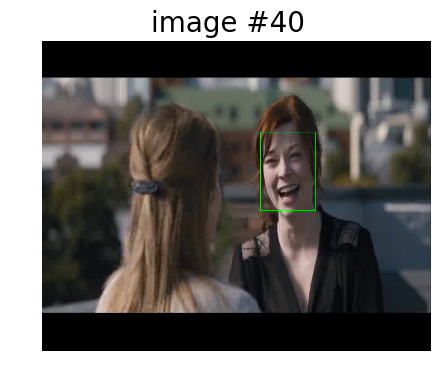

[1]: 49
[2]: 49
[4]: 49
[4.5]: 49
[5]: 7
[6]: 7
[7]: 7
[8]: 7
2: (7L, 5L)
[9]: 4
[10]: 4
[11]: 1
3: (1L, 5L)
Elapsed: 0.108999967575 s


In [ ]:
if __name__ == "__main__":
    main()